In [1]:
import sys
sys.path.append("../")
import numpy as np
from qscore2 import Qscore2
from iotbx.data_manager import DataManager

In [37]:

#model = "../clutter/data/6cvm_frag_B100.pdb"
model = "../clutter/data/6cvm.pdb"
map = "../test_data/6cvm/emd_7770.map"
dm = DataManager()
dm.process_model_file(model)
dm.process_real_map_file(map)
mmm = dm.get_map_model_manager()
mm = mmm.map_manager()
model = mmm.model()
d_min = mmm.resolution()
volume = mm.map_data().as_numpy_array()
atoms_xyz = model.get_sites_cart().as_numpy_array()
voxel_size = mm.pixel_sizes()[0]
grid_shape = volume.shape

In [38]:
%%time
rtol = 0.9
rads = np.arange(0.1,2.1,0.1)
n_probes = 64
selection_string = "all"
selection = model.selection(selection_string).as_numpy_array()
q,probe_xyz,keep_mask,d_vals,g_vals = Qscore2(volume,
                                            atoms_xyz,
                                            mask_clash=True,
                                            voxel_size=voxel_size,
                                            n_probes=n_probes,
                                            min_probes=1,
                                            radii=rads,
                                            ignore_min_probes=False,
                                            selection_bool=selection,
                                            rtol=rtol,
                                            num_processes=10
                                            )

CPU times: user 6.49 s, sys: 5.15 s, total: 11.6 s
Wall time: 18.5 s


In [39]:
# compare to actual mapq
dm = DataManager()
dm.process_model_file("/Users/user/Dropbox/Mac/Desktop/qscore2/clutter/data/6cvm_B100.pdb")
ref_model = dm.get_model()
ref_q = 1-(ref_model.get_atoms().extract_b().as_numpy_array()/100)
ref_q = ref_q[selection]

CC: 0.9691696514934688


Text(5.541666666666666, 0.5, 'Q-score2')

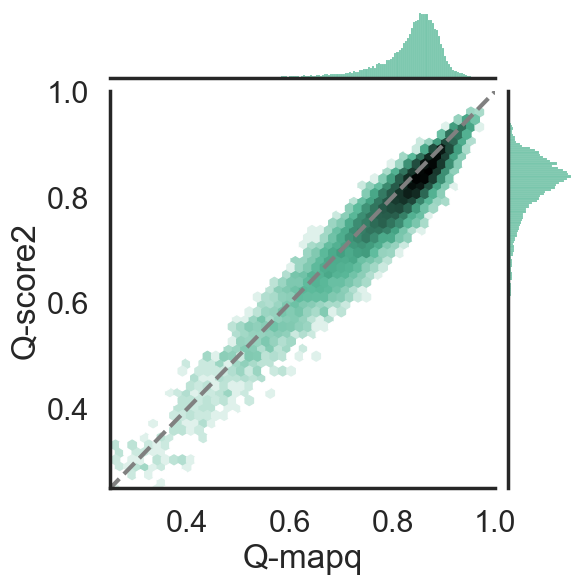

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sns.set_theme(style="white", context="poster")

#plt.style.use('seaborn-poster')
x,y = ref_q,q
print("CC:",np.corrcoef(x,y)[0][1])
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 100})
fig.ax_joint.collections[0].set_norm(LogNorm())
#fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
#plt.xlim(0.5,1)
#plt.ylim(0.5,1)
plt.xlim(0.25,1)
plt.ylim(0.25,1)
plt.xlabel("Q-mapq")
plt.ylabel("Q-score2")

In [28]:
def points_to_bild(points,outfile="debug.bild",radius=0.1,color="purple"):
    """
    Write a .bild file to vizualize radial points in Chimera.
    
    Args:
        points: np array of shape (n_points,3)
        outfile: File path to write out
        radius: radius to use when depicting the points
        color: color of points. One of the Chimera color keywords
    """
    colors = ["red","yellow","orange","lime","forest green","cyan","cornflower blue","purple","magenta","gray"]
    if color is None:
        color = random.choice(colors)
    bild_lines = []
    for p in np.vstack(points):
        s = ".color "+color+"\n.sphere "+" ".join(str(v) for v in p)+" %s"%str(radius)+"\n"
        bild_lines.append(s)
    with open(outfile,"w") as fh:
        fh.writelines(bild_lines)

In [29]:
# get probes to write
points_to_bild(probe_xyz[9].reshape(-1,3)[keep_mask[9].reshape(-1)],outfile="my_radius1.bild")

In [ ]:
fig,axes = plt.subplots((6,6))
axes = axes.flatten()
i_vals = random.choice(np.arange(len(

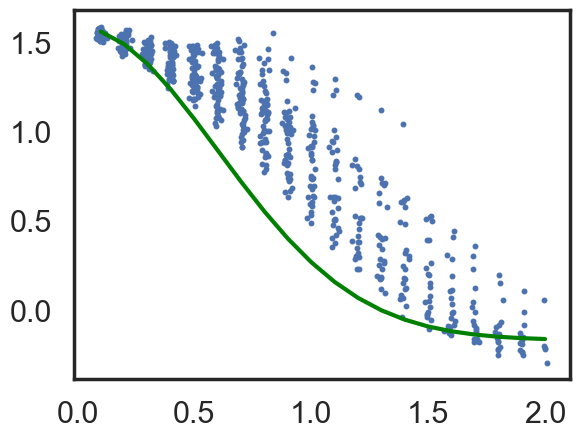

In [7]:
i = 200
s = 5
x_repeat = np.repeat(rads,keep_mask.shape[-1])
jitter = np.random.standard_normal(x_repeat.shape[0])*0.01
mask= keep_mask[:,i,:].ravel()
plt.scatter(x_repeat[mask]+jitter[mask],d_vals[:,i].ravel()[mask],s=s)
plt.plot(x_repeat,g_vals[:,i].ravel(),color="green")

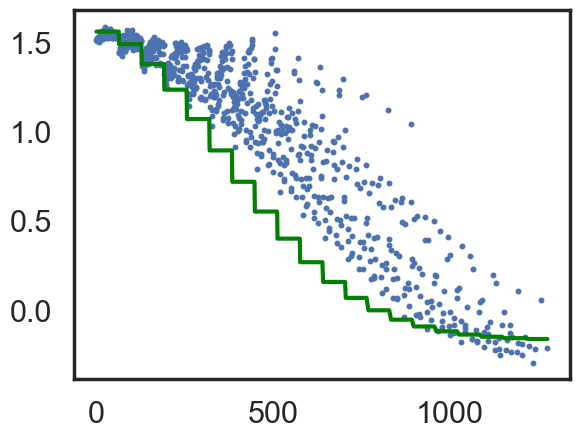

In [49]:
i = 200
N = len(d_vals[:,i].ravel())
plt.scatter(np.arange(N)[mask],d_vals[:,i].ravel()[mask],s=s)
plt.plot(np.arange(N)[mask],g_vals[:,i].ravel()[mask],color="green")

In [6]:
# compare to cc atoms
from mmtbx.maps.correlation import from_map_map_atoms_per_atom

d_obs = mmm.map_manager().map_data().as_numpy_array()
mmm.generate_map(d_min=d_min,model=mmm.model(),map_id="calc1")
mmm.generate_map(d_min=d_min+0.5,model=mmm.model(),map_id="calc2")
d_calc1 = mmm.get_map_data_by_id(map_id="calc1").as_numpy_array()
d_calc2 = mmm.get_map_data_by_id(map_id="calc2").as_numpy_array()


cc_atoms = from_map_map_atoms_per_atom(mmm.map_manager().map_data(),
                            mmm.get_map_data_by_id(map_id="calc1"),
                            model.get_sites_cart(),
                            model.unit_cell_crystal_symmetry().unit_cell(),
                            2.0)
cc_atoms_np = cc_atoms.as_numpy_array()

CC: 0.3702352385589294


Text(5.541666666666666, 0.5, 'CCatoms')

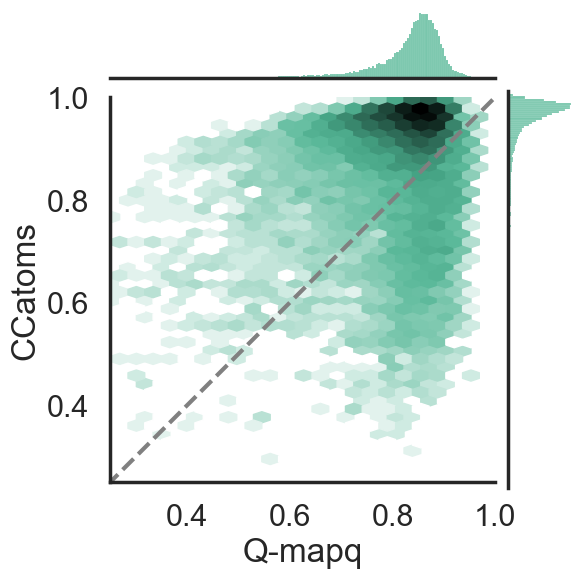

In [13]:
from matplotlib.colors import LogNorm

x,y = ref_q,cc_atoms_np
print("CC:",np.corrcoef(x,y)[0][1])
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 50})
fig.ax_joint.collections[0].set_norm(LogNorm())
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
#plt.xlim(0.5,1)
#plt.ylim(0.5,1)
plt.xlim(0.25,1)
plt.ylim(0.25,1)
plt.xlabel("Q-mapq")
plt.ylabel("CCatoms")

CC: 0.3624119483102291


Text(5.541666666666666, 0.5, 'CCatoms')

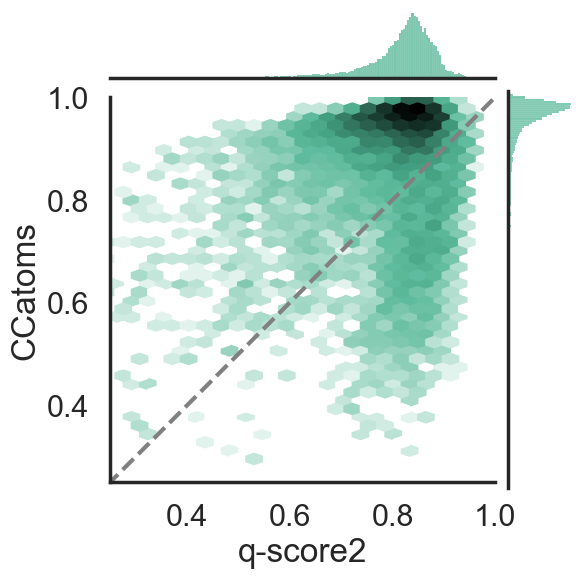

In [12]:
from matplotlib.colors import LogNorm

x,y = q,cc_atoms_np
print("CC:",np.corrcoef(x,y)[0][1])
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 50})
fig.ax_joint.collections[0].set_norm(LogNorm())
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
#plt.xlim(0.5,1)
#plt.ylim(0.5,1)
plt.xlim(0.25,1)
plt.ylim(0.25,1)
plt.xlabel("q-score2")
plt.ylabel("CCatoms")

In [33]:
q.shape

(43,)

In [30]:
sns.histplot(q-ref_q)

ValueError: operands could not be broadcast together with shapes (43,) (37062,) 

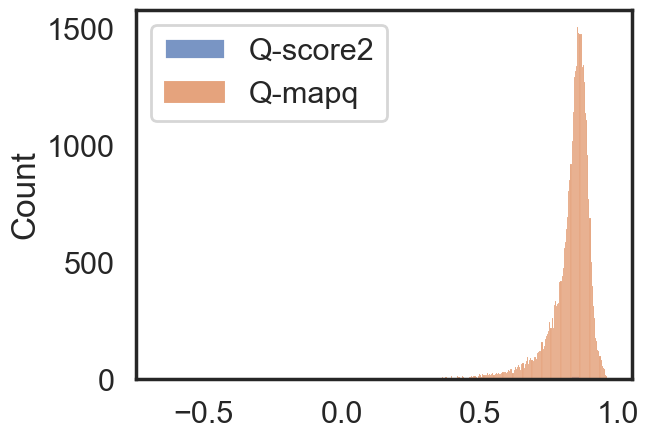

In [31]:
sns.histplot(q,label="Q-score2")
sns.histplot(ref_q,label="Q-mapq")
plt.legend()

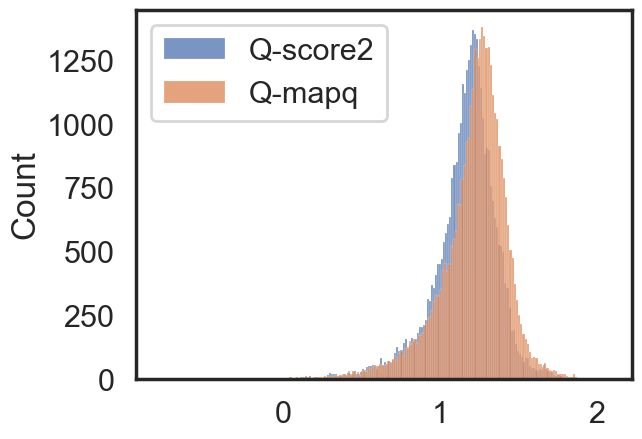

In [45]:
def fisher(r):
    z = 0.5 * np.log((1 + r) / (1 - r))
    return z

sns.histplot(fisher(q),label="Q-score2")
sns.histplot(fisher(ref_q),label="Q-mapq")
plt.legend()

In [30]:
sel = (low<fisher(q)) & (fisher(q)<high)

(-1.0, 2.0)

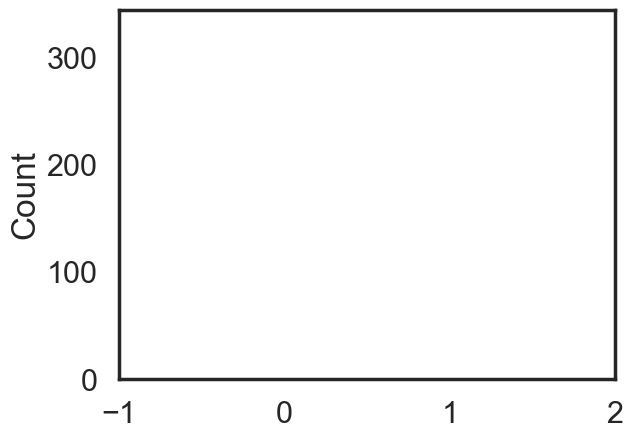

In [33]:
sns.histplot(fisher(q)[sel])
plt.xlim(-1,2)